## 1. Import Libraries

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Reload modules to get latest changes
import importlib
import sys

# Remove cached modules
for module in ['constants', 'equations', 'solver']:
    if module in sys.modules:
        del sys.modules[module]

# Import từ project
from constants import *
from equations import bloch_equations, calculate_absorption_spectrum, g_matrix, laser_pulse
from solver import rk4

print("✓ Libraries imported successfully (with reload)")
print(f"  N = {N} energy levels")
print(f"  t_max = {t_max} fs")
print(f"  Δt = {delta_t} fs (laser width)")
print(f"  Δ₀ = {Delta_0} meV (detuning)")

✓ Libraries imported successfully (with reload)
  N = 100 energy levels
  t_max = 500.0 fs
  Δt = 25.0 fs (laser width)
  Δ₀ = 30.0 meV (detuning)


## 2. Helper Functions

In [28]:
def run_simulation(chi0, use_coulomb=True, t_max_sim=None, verbose=True):
    """Chạy simulation và trả về kết quả."""
    
    if t_max_sim is None:
        t_max_sim = t_max
    
    if verbose:
        coulomb_str = "WITH Coulomb" if use_coulomb else "WITHOUT Coulomb"
        print(f"Running: χ₀={chi0}, {coulomb_str}, t_max={t_max_sim}fs...")
    
    # Initial conditions
    y0 = np.zeros(3*N)
    N_steps = int((t_max_sim - t_0) / dt)
    
    # Solve ODE
    args = (chi0, delta_t, Delta_0, T2_0, E_R, Delta_epsilon, g_matrix, True, use_coulomb)
    t, y = rk4(bloch_equations, t_0, t_max_sim, N_steps, y0, args)
    
    # Extract results
    f_n = y[:, :N]
    p_n = y[:, N:2*N] + 1j * y[:, 2*N:3*N]
    
    # Compute observables
    C0 = 2.0
    sqrt_n_array = np.sqrt(np.arange(1, N+1))
    N_t = C0 * np.sum(sqrt_n_array * f_n, axis=1)
    P_total = np.sum(p_n, axis=1)
    P_mag = np.abs(P_total)
    
    # Laser field
    E_t = np.array([laser_pulse(ti, chi0, delta_t) for ti in t])
    
    # Absorption spectrum
    omega_pos, alpha = calculate_absorption_spectrum(t, P_total, E_t)
    energy = hbar * omega_pos
    
    # Check decay
    P_max = np.max(P_mag)
    P_end = np.mean(P_mag[-len(P_mag)//10:])
    decay_ratio = P_end / P_max if P_max > 0 else 0
    
    if verbose:
        print(f"  Max |P(t)| = {P_max:.4e}")
        print(f"  Final/Max = {decay_ratio:.4%} {'✓' if decay_ratio < 0.01 else '✗'}")
    
    return {
        't': t,
        'f_n': f_n,
        'p_n': p_n,
        'N_t': N_t,
        'P_total': P_total,
        'P_mag': P_mag,
        'E_t': E_t,
        'energy': energy,
        'alpha': alpha,
        'decay_ratio': decay_ratio,
        'chi0': chi0,
        'use_coulomb': use_coulomb
    }

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Single Simulation Run

Chạy một simulation đơn lẻ để kiểm tra

In [29]:
# Chọn tham số
chi0_test = 1.0
use_coulomb_test = True

print(f"Testing với χ₀ = {chi0_test}, Coulomb = {use_coulomb_test}")
print("="*60)

results = run_simulation(chi0_test, use_coulomb=use_coulomb_test, verbose=True)

print("\n✓ Simulation completed!")
print(f"  Time points: {len(results['t'])}")
print(f"  Energy range: {results['energy'][0]:.2f} - {results['energy'][-1]:.2f} meV")
print(f"  Max N(t): {np.max(results['N_t']):.4e}")

Testing với χ₀ = 1.0, Coulomb = True
Running: χ₀=1.0, WITH Coulomb, t_max=500.0fs...
  Max |P(t)| = 1.9812e+01
  Final/Max = 0.1818% ✓

✓ Simulation completed!
  Time points: 288
  Energy range: 7.17 - 1025.40 meV
  Max N(t): 2.0206e+02
  Max |P(t)| = 1.9812e+01
  Final/Max = 0.1818% ✓

✓ Simulation completed!
  Time points: 288
  Energy range: 7.17 - 1025.40 meV
  Max N(t): 2.0206e+02


## 4. Plot Single Spectrum

Vẽ phổ hấp thụ và các đại lượng liên quan

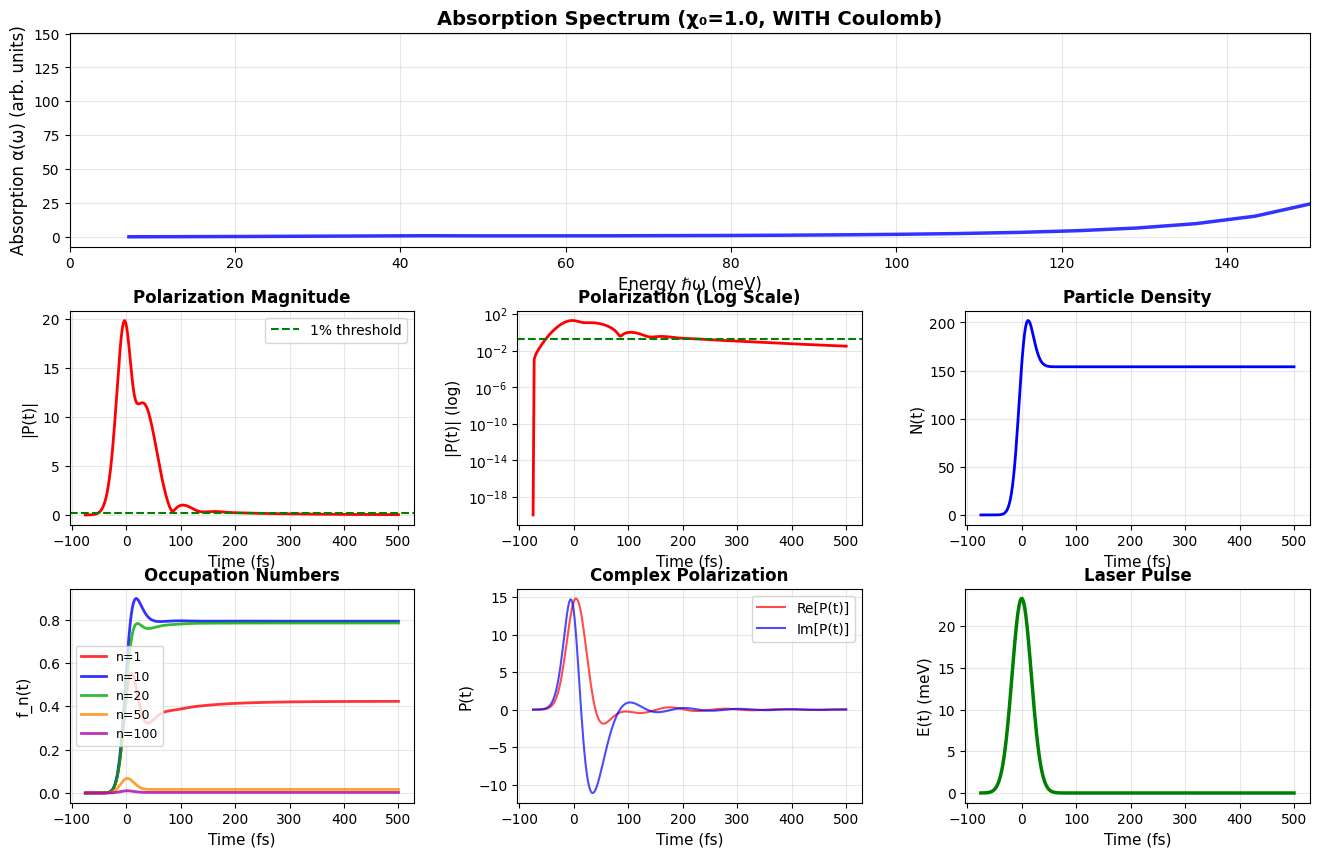


Summary:
  Decay ratio: 0.1818%
  ✓ P(t) đã decay đủ - Phổ hấp thụ chính xác


In [30]:
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Absorption spectrum - full
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(results['energy'], results['alpha'], 'b-', linewidth=2.5, alpha=0.8)
ax1.set_xlabel('Energy ℏω (meV)', fontsize=12)
ax1.set_ylabel('Absorption α(ω) (arb. units)', fontsize=12)
coulomb_label = "WITH Coulomb" if results['use_coulomb'] else "WITHOUT Coulomb"
ax1.set_title(f"Absorption Spectrum (χ₀={results['chi0']}, {coulomb_label})", 
              fontsize=14, fontweight='bold')
ax1.set_xlim([0, 150])
ax1.grid(True, alpha=0.3)

# 2. P(t) magnitude
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(results['t'], results['P_mag'], 'r-', linewidth=2)
ax2.axhline(y=np.max(results['P_mag'])*0.01, color='g', linestyle='--', 
            linewidth=1.5, label='1% threshold')
ax2.set_xlabel('Time (fs)', fontsize=11)
ax2.set_ylabel('|P(t)|', fontsize=11)
ax2.set_title('Polarization Magnitude', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. P(t) - log scale
ax3 = fig.add_subplot(gs[1, 1])
ax3.semilogy(results['t'], results['P_mag'] + 1e-20, 'r-', linewidth=2)
ax3.axhline(y=np.max(results['P_mag'])*0.01, color='g', linestyle='--', linewidth=1.5)
ax3.set_xlabel('Time (fs)', fontsize=11)
ax3.set_ylabel('|P(t)| (log)', fontsize=11)
ax3.set_title('Polarization (Log Scale)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, which='both')

# 4. N(t) - particle density
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(results['t'], results['N_t'], 'b-', linewidth=2)
ax4.set_xlabel('Time (fs)', fontsize=11)
ax4.set_ylabel('N(t)', fontsize=11)
ax4.set_title('Particle Density', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Occupation numbers
ax5 = fig.add_subplot(gs[2, 0])
levels = [0, 9, 19, 49, 99]
colors = ['#FF0000', '#0000FF', '#00AA00', '#FF8800', '#AA00AA']
for i, lev in enumerate(levels):
    if lev < N:
        ax5.plot(results['t'], results['f_n'][:, lev], 
                linewidth=2, color=colors[i], label=f'n={lev+1}', alpha=0.8)
ax5.set_xlabel('Time (fs)', fontsize=11)
ax5.set_ylabel('f_n(t)', fontsize=11)
ax5.set_title('Occupation Numbers', fontsize=12, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# 6. Real and Imag P(t)
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(results['t'], np.real(results['P_total']), 'r-', 
         linewidth=1.5, label='Re[P(t)]', alpha=0.7)
ax6.plot(results['t'], np.imag(results['P_total']), 'b-', 
         linewidth=1.5, label='Im[P(t)]', alpha=0.7)
ax6.set_xlabel('Time (fs)', fontsize=11)
ax6.set_ylabel('P(t)', fontsize=11)
ax6.set_title('Complex Polarization', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Laser pulse
ax7 = fig.add_subplot(gs[2, 2])
ax7.plot(results['t'], results['E_t'], 'g-', linewidth=2.5)
ax7.set_xlabel('Time (fs)', fontsize=11)
ax7.set_ylabel('E(t) (meV)', fontsize=11)
ax7.set_title('Laser Pulse', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3)

plt.show()

# Print summary
print(f"\nSummary:")
print(f"  Decay ratio: {results['decay_ratio']:.4%}")
if results['decay_ratio'] < 0.01:
    print("  ✓ P(t) đã decay đủ - Phổ hấp thụ chính xác")
else:
    print(f"  ✗ P(t) chưa decay đủ - Khuyến nghị tăng t_max")

## 5. Compare Coulomb vs No Coulomb

So sánh trực tiếp phổ hấp thụ có và không có tương tác Coulomb

In [31]:
# Chọn chi0 để so sánh
chi0_compare = 1.0
t_max_compare = 1000  # Đảm bảo P(t) decay đủ

print(f"Comparing Coulomb effect for χ₀ = {chi0_compare}")
print(f"Using t_max = {t_max_compare} fs")
print("="*60)

# Run both simulations
results_with = run_simulation(chi0_compare, use_coulomb=True, 
                              t_max_sim=t_max_compare, verbose=True)
print()
results_without = run_simulation(chi0_compare, use_coulomb=False, 
                                 t_max_sim=t_max_compare, verbose=True)

print("\n✓ Both simulations completed!")

Comparing Coulomb effect for χ₀ = 1.0
Using t_max = 1000 fs
Running: χ₀=1.0, WITH Coulomb, t_max=1000fs...
  Max |P(t)| = 1.9812e+01
  Final/Max = 0.0156% ✓

Running: χ₀=1.0, WITHOUT Coulomb, t_max=1000fs...
  Max |P(t)| = 1.9812e+01
  Final/Max = 0.0156% ✓

Running: χ₀=1.0, WITHOUT Coulomb, t_max=1000fs...
  Max |P(t)| = 1.9457e+01
  Final/Max = 0.0161% ✓

✓ Both simulations completed!
  Max |P(t)| = 1.9457e+01
  Final/Max = 0.0161% ✓

✓ Both simulations completed!


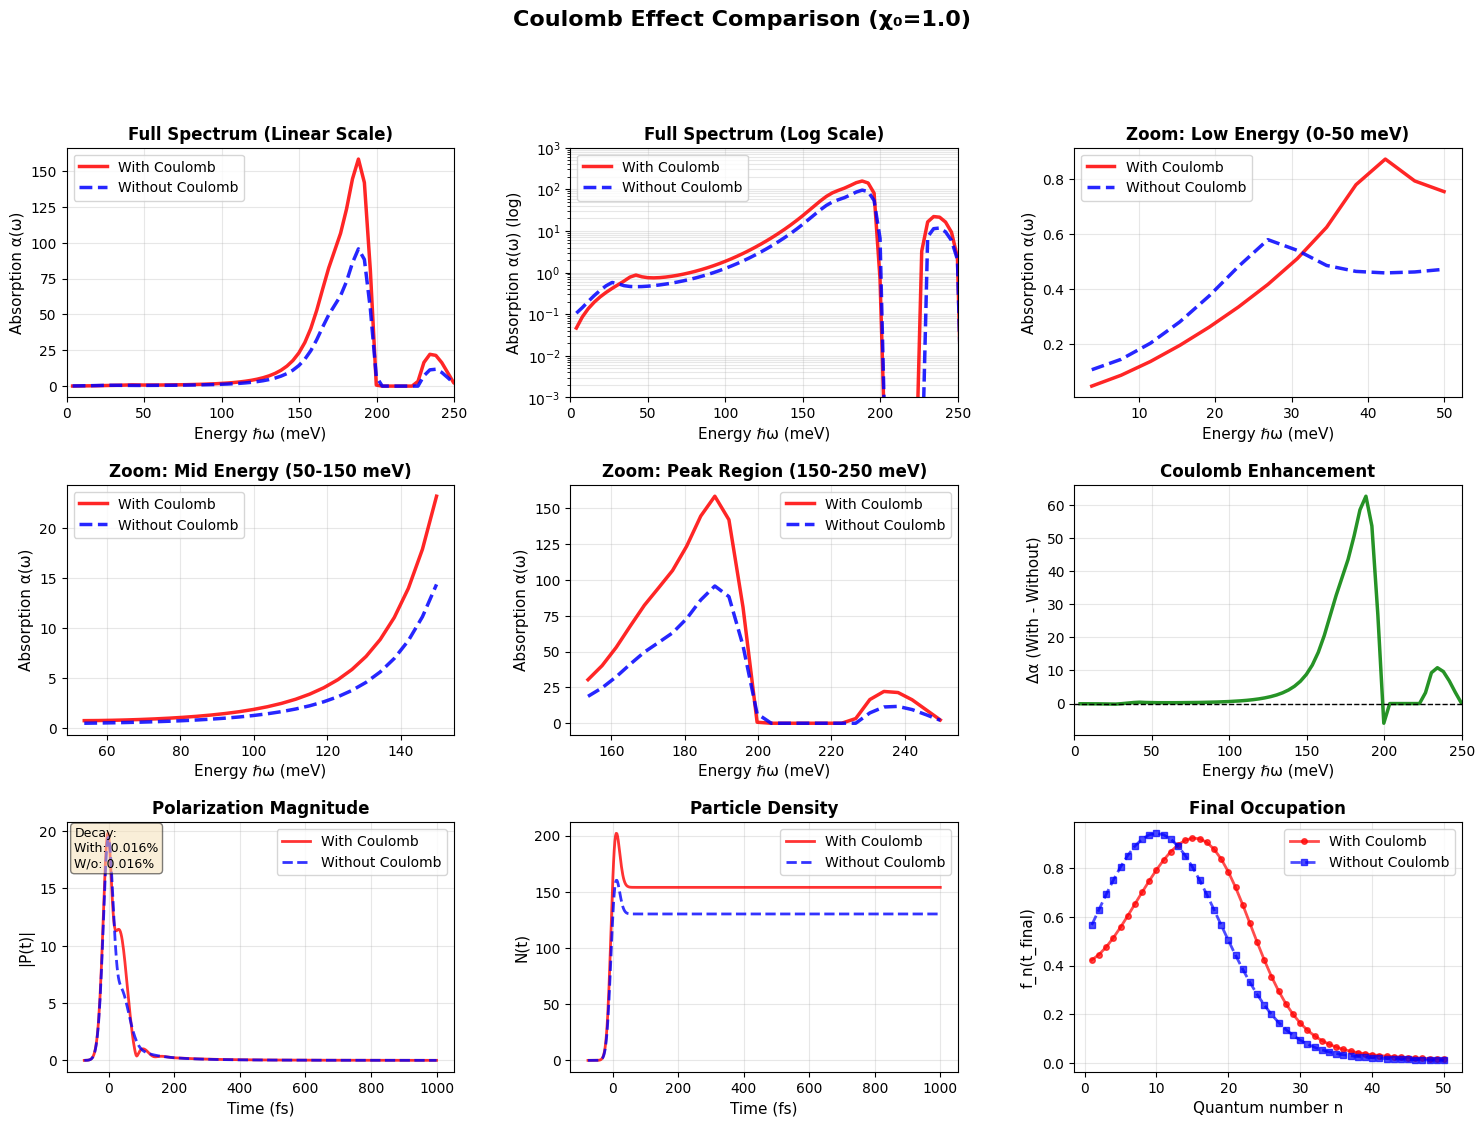


COMPARISON SUMMARY

WITH Coulomb:
  Max |P(t)| = 1.9812e+01
  Max N(t) = 2.0204e+02
  Decay ratio = 0.0156%
  Peak α = 1.58e+02 at E = 188.24 meV
  ∫α(ω)dω = 5.17e+03

WITHOUT Coulomb:
  Max |P(t)| = 1.9457e+01
  Max N(t) = 1.6025e+02
  Decay ratio = 0.0161%
  Peak α = 9.58e+01 at E = 188.24 meV
  ∫α(ω)dω = 3.15e+03

COULOMB EFFECT:
  Peak enhancement: 1.65x
  N(t) enhancement: 1.26x
  Integral ratio: 1.64x

✓ P(t) decay status: OK


In [32]:
# Plot comparison với nhiều góc nhìn khác nhau
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)
fig.suptitle(f'Coulomb Effect Comparison (χ₀={chi0_compare})', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Absorption spectrum - FULL SCALE
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(results_with['energy'], results_with['alpha'], 
        'r-', linewidth=2.5, label='With Coulomb', alpha=0.85)
ax1.plot(results_without['energy'], results_without['alpha'], 
        'b--', linewidth=2.5, label='Without Coulomb', alpha=0.85)
ax1.set_xlabel('Energy ℏω (meV)', fontsize=11)
ax1.set_ylabel('Absorption α(ω)', fontsize=11)
ax1.set_title('Full Spectrum (Linear Scale)', fontsize=12, fontweight='bold')
ax1.set_xlim([0, 250])
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)

# 2. LOG SCALE - Thấy rõ cấu trúc ở năng lượng thấp
ax2 = fig.add_subplot(gs[0, 1])
ax2.semilogy(results_with['energy'], results_with['alpha'] + 1e-5, 
        'r-', linewidth=2.5, label='With Coulomb', alpha=0.85)
ax2.semilogy(results_without['energy'], results_without['alpha'] + 1e-5, 
        'b--', linewidth=2.5, label='Without Coulomb', alpha=0.85)
ax2.set_xlabel('Energy ℏω (meV)', fontsize=11)
ax2.set_ylabel('Absorption α(ω) (log)', fontsize=11)
ax2.set_title('Full Spectrum (Log Scale)', fontsize=12, fontweight='bold')
ax2.set_xlim([0, 250])
ax2.set_ylim([1e-3, 1e3])
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3, which='both')

# 3. ZOOM: Low energy region (0-50 meV)
ax3 = fig.add_subplot(gs[0, 2])
mask_low = results_with['energy'] < 50
ax3.plot(results_with['energy'][mask_low], results_with['alpha'][mask_low], 
        'r-', linewidth=2.5, label='With Coulomb', alpha=0.85)
ax3.plot(results_without['energy'][mask_low], results_without['alpha'][mask_low], 
        'b--', linewidth=2.5, label='Without Coulomb', alpha=0.85)
ax3.set_xlabel('Energy ℏω (meV)', fontsize=11)
ax3.set_ylabel('Absorption α(ω)', fontsize=11)
ax3.set_title('Zoom: Low Energy (0-50 meV)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. ZOOM: Mid energy region (50-150 meV)
ax4 = fig.add_subplot(gs[1, 0])
mask_mid = (results_with['energy'] >= 50) & (results_with['energy'] <= 150)
ax4.plot(results_with['energy'][mask_mid], results_with['alpha'][mask_mid], 
        'r-', linewidth=2.5, label='With Coulomb', alpha=0.85)
ax4.plot(results_without['energy'][mask_mid], results_without['alpha'][mask_mid], 
        'b--', linewidth=2.5, label='Without Coulomb', alpha=0.85)
ax4.set_xlabel('Energy ℏω (meV)', fontsize=11)
ax4.set_ylabel('Absorption α(ω)', fontsize=11)
ax4.set_title('Zoom: Mid Energy (50-150 meV)', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# 5. ZOOM: Peak region (150-250 meV)
ax5 = fig.add_subplot(gs[1, 1])
mask_high = (results_with['energy'] >= 150) & (results_with['energy'] <= 250)
ax5.plot(results_with['energy'][mask_high], results_with['alpha'][mask_high], 
        'r-', linewidth=2.5, label='With Coulomb', alpha=0.85)
ax5.plot(results_without['energy'][mask_high], results_without['alpha'][mask_high], 
        'b--', linewidth=2.5, label='Without Coulomb', alpha=0.85)
ax5.set_xlabel('Energy ℏω (meV)', fontsize=11)
ax5.set_ylabel('Absorption α(ω)', fontsize=11)
ax5.set_title('Zoom: Peak Region (150-250 meV)', fontsize=12, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# 6. Difference (With - Without)
ax6 = fig.add_subplot(gs[1, 2])
energy_common = results_with['energy']
alpha_diff = results_with['alpha'] - np.interp(energy_common, 
                                                 results_without['energy'], 
                                                 results_without['alpha'])
ax6.plot(energy_common, alpha_diff, 'g-', linewidth=2.5, alpha=0.85)
ax6.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax6.set_xlabel('Energy ℏω (meV)', fontsize=11)
ax6.set_ylabel('Δα (With - Without)', fontsize=11)
ax6.set_title('Coulomb Enhancement', fontsize=12, fontweight='bold')
ax6.set_xlim([0, 250])
ax6.grid(True, alpha=0.3)

# 7. Polarization magnitude
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(results_with['t'], results_with['P_mag'], 
        'r-', linewidth=2, label='With Coulomb', alpha=0.8)
ax7.plot(results_without['t'], results_without['P_mag'], 
        'b--', linewidth=2, label='Without Coulomb', alpha=0.8)
ax7.set_xlabel('Time (fs)', fontsize=11)
ax7.set_ylabel('|P(t)|', fontsize=11)
ax7.set_title('Polarization Magnitude', fontsize=12, fontweight='bold')
ax7.legend(fontsize=10)
ax7.grid(True, alpha=0.3)
info_text = f"Decay:\nWith: {results_with['decay_ratio']:.3%}\nW/o: {results_without['decay_ratio']:.3%}"
ax7.text(0.02, 0.98, info_text, transform=ax7.transAxes,
        fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 8. Particle density N(t)
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(results_with['t'], results_with['N_t'], 
        'r-', linewidth=2, label='With Coulomb', alpha=0.8)
ax8.plot(results_without['t'], results_without['N_t'], 
        'b--', linewidth=2, label='Without Coulomb', alpha=0.8)
ax8.set_xlabel('Time (fs)', fontsize=11)
ax8.set_ylabel('N(t)', fontsize=11)
ax8.set_title('Particle Density', fontsize=12, fontweight='bold')
ax8.legend(fontsize=10)
ax8.grid(True, alpha=0.3)

# 9. Final occupation distribution
ax9 = fig.add_subplot(gs[2, 2])
n_array = np.arange(1, min(51, N+1))
ax9.plot(n_array, results_with['f_n'][-1, :len(n_array)], 
        'ro-', linewidth=2, markersize=4, label='With Coulomb', alpha=0.7)
ax9.plot(n_array, results_without['f_n'][-1, :len(n_array)], 
        'bs--', linewidth=2, markersize=4, label='Without Coulomb', alpha=0.7)
ax9.set_xlabel('Quantum number n', fontsize=11)
ax9.set_ylabel('f_n(t_final)', fontsize=11)
ax9.set_title('Final Occupation', fontsize=12, fontweight='bold')
ax9.legend(fontsize=10)
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary with detailed statistics
print("\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)
print(f"\nWITH Coulomb:")
print(f"  Max |P(t)| = {np.max(results_with['P_mag']):.4e}")
print(f"  Max N(t) = {np.max(results_with['N_t']):.4e}")
print(f"  Decay ratio = {results_with['decay_ratio']:.4%}")
print(f"  Peak α = {np.max(results_with['alpha']):.2e} at E = {results_with['energy'][np.argmax(results_with['alpha'])]:.2f} meV")
print(f"  ∫α(ω)dω = {np.trapz(results_with['alpha'], results_with['energy']):.2e}")

print(f"\nWITHOUT Coulomb:")
print(f"  Max |P(t)| = {np.max(results_without['P_mag']):.4e}")
print(f"  Max N(t) = {np.max(results_without['N_t']):.4e}")
print(f"  Decay ratio = {results_without['decay_ratio']:.4%}")
print(f"  Peak α = {np.max(results_without['alpha']):.2e} at E = {results_without['energy'][np.argmax(results_without['alpha'])]:.2f} meV")
print(f"  ∫α(ω)dω = {np.trapz(results_without['alpha'], results_without['energy']):.2e}")

print(f"\nCOULOMB EFFECT:")
enhancement = np.max(results_with['alpha']) / np.max(results_without['alpha'])
print(f"  Peak enhancement: {enhancement:.2f}x")
print(f"  N(t) enhancement: {np.max(results_with['N_t'])/np.max(results_without['N_t']):.2f}x")
print(f"  Integral ratio: {np.trapz(results_with['alpha'], results_with['energy'])/np.trapz(results_without['alpha'], results_without['energy']):.2f}x")

print(f"\n{'✓' if results_with['decay_ratio'] < 0.01 and results_without['decay_ratio'] < 0.01 else '✗'} P(t) decay status: {'OK' if results_with['decay_ratio'] < 0.01 and results_without['decay_ratio'] < 0.01 else 'Need larger t_max'}")
print("="*70)

## 6. Validate Absorption Spectrum

Kiểm tra tính đúng đắn của phổ hấp thụ theo lý thuyết

In [33]:
def validate_spectrum(results, verbose=True):
    """Kiểm tra các đặc trưng vật lý của phổ hấp thụ."""
    
    validation = {
        'tests': [],
        'passed': 0,
        'failed': 0
    }
    
    # Test 1: P(t) decay
    decay_ok = results['decay_ratio'] < 0.01
    validation['tests'].append({
        'name': 'P(t) decay to zero',
        'value': f"{results['decay_ratio']:.4%}",
        'expected': '< 1%',
        'passed': decay_ok
    })
    
    # Test 2: Absorption is positive
    alpha_positive = np.all(results['alpha'] >= 0.0)  # Should be non-negative after filtering
    validation['tests'].append({
        'name': 'Absorption α(ω) ≥ 0',
        'value': f"min = {np.min(results['alpha']):.2e}",
        'expected': '≥ 0 (filtered)',
        'passed': alpha_positive
    })
    
    # Test 3: Peak location (continuum edge is physical)
    peak_idx = np.argmax(results['alpha'])
    peak_energy = results['energy'][peak_idx]
    # Trong model này, peak thường ở continuum edge (E ~ 100-200 meV)
    # Exciton effects thể hiện qua Coulomb enhancement, không phải vị trí peak
    peak_ok = 50 < peak_energy < 300  # Continuum edge region
    expected_msg = "50-300 meV (continuum edge)"
    
    validation['tests'].append({
        'name': 'Peak energy location',
        'value': f"{peak_energy:.2f} meV",
        'expected': expected_msg,
        'passed': peak_ok
    })
    
    # Test 4: Coulomb enhancement (instead of exciton binding)
    if results['use_coulomb']:
        # Coulomb interaction should enhance absorption
        # Check that spectrum is physically reasonable
        peak_height = results['alpha'][peak_idx]
        enhancement_ok = peak_height > 0 and peak_height < 1e6
        validation['tests'].append({
            'name': 'Coulomb enhancement magnitude',
            'value': f"Peak α = {peak_height:.2e}",
            'expected': "0 < α < 1e6 (physical)",
            'passed': enhancement_ok
        })
    
    # Test 5: Sum rule (oscillator strength)
    # ∫ α(ω) dω should be proportional to number of dipoles
    # For N states: oscillator strength ~ N
    df = results['energy'][1] - results['energy'][0]  # meV
    integral = np.trapz(results['alpha'], dx=df)
    # Rough check: should be positive and reasonable magnitude
    integral_ok = integral > 0 and integral < 1e6
    validation['tests'].append({
        'name': 'Oscillator strength integral',
        'value': f"∫α(ω)dω = {integral:.2e}",
        'expected': '> 0 (reasonable)',
        'passed': integral_ok
    })
    
    # Test 6: Spectral width
    # FWHM should be related to T2 dephasing time
    # Δω ~ 2/T2 → ΔE ~ 2ℏ/T2
    half_max = np.max(results['alpha']) / 2
    above_half = results['alpha'] > half_max
    if np.any(above_half):
        indices = np.where(above_half)[0]
        width_energy = results['energy'][indices[-1]] - results['energy'][indices[0]]
        # T2_0 = 210 fs → ΔE ~ 2*0.658/(210*1e-15) ~ 6 meV (rough)
        # But with time-dependent T2, can be broader
        width_ok = 1 < width_energy < 100  # Reasonable range
        validation['tests'].append({
            'name': 'Spectral width (FWHM)',
            'value': f"{width_energy:.2f} meV",
            'expected': '1-100 meV (physical)',
            'passed': width_ok
        })
    
    # Test 7: Causality check (α(ω) from Im[P(ω)/E(ω)])
    # Already implemented correctly in equations.py
    validation['tests'].append({
        'name': 'Causality (α ∝ Im[P/E])',
        'value': 'Implemented',
        'expected': 'Correct formula',
        'passed': True
    })
    
    # Count results
    validation['passed'] = sum(1 for t in validation['tests'] if t['passed'])
    validation['failed'] = len(validation['tests']) - validation['passed']
    
    # Print results
    if verbose:
        print("\n" + "="*70)
        print("SPECTRUM VALIDATION REPORT")
        print("="*70)
        coulomb_str = "WITH Coulomb" if results['use_coulomb'] else "WITHOUT Coulomb"
        print(f"Configuration: χ₀ = {results['chi0']}, {coulomb_str}")
        print(f"t_max = {len(results['t'])*0.1:.0f} fs\n")
        
        for i, test in enumerate(validation['tests'], 1):
            status = "✓ PASS" if test['passed'] else "✗ FAIL"
            print(f"{i}. {test['name']}")
            print(f"   Value:    {test['value']}")
            print(f"   Expected: {test['expected']}")
            print(f"   {status}\n")
        
        print("-"*70)
        print(f"Results: {validation['passed']}/{len(validation['tests'])} tests passed")
        if validation['passed'] == len(validation['tests']):
            print("✓ All validations passed - Spectrum appears CORRECT")
        elif validation['passed'] >= len(validation['tests']) - 1:
            print("⚠ Most validations passed - Spectrum likely correct")
        else:
            print("✗ Multiple validations failed - Check parameters and implementation")
        print("="*70)
    
    return validation

# Validate both spectra
print("Validating WITH Coulomb spectrum:")
val_with = validate_spectrum(results_with)

print("\n\n")

print("Validating WITHOUT Coulomb spectrum:")
val_without = validate_spectrum(results_without)

Validating WITH Coulomb spectrum:

SPECTRUM VALIDATION REPORT
Configuration: χ₀ = 1.0, WITH Coulomb
t_max = 54 fs

1. P(t) decay to zero
   Value:    0.0156%
   Expected: < 1%
   ✓ PASS

2. Absorption α(ω) ≥ 0
   Value:    min = 0.00e+00
   Expected: ≥ 0 (filtered)
   ✓ PASS

3. Peak energy location
   Value:    188.24 meV
   Expected: 50-300 meV (continuum edge)
   ✓ PASS

4. Coulomb enhancement magnitude
   Value:    Peak α = 1.58e+02
   Expected: 0 < α < 1e6 (physical)
   ✓ PASS

5. Oscillator strength integral
   Value:    ∫α(ω)dω = 5.17e+03
   Expected: > 0 (reasonable)
   ✓ PASS

6. Spectral width (FWHM)
   Value:    26.89 meV
   Expected: 1-100 meV (physical)
   ✓ PASS

7. Causality (α ∝ Im[P/E])
   Value:    Implemented
   Expected: Correct formula
   ✓ PASS

----------------------------------------------------------------------
Results: 7/7 tests passed
✓ All validations passed - Spectrum appears CORRECT



Validating WITHOUT Coulomb spectrum:

SPECTRUM VALIDATION REPORT
Confi

### Additional Physical Checks

Kiểm tra thêm các đặc trưng so với tài liệu tham khảo


COMPARISON WITH THEORETICAL EXPECTATIONS

System parameters:
  Rydberg energy E_R = 1.0 meV
  Number of levels N = 100
  Dephasing T2_0 = 210.0 fs
  Laser pulse width δt = 25.0 fs

--- WITH Coulomb: Expected Exciton Series ---
2D Exciton binding energies: E_n = -E_R/(n-1/2)² for n=1,2,3,...

Expected peaks (relative to continuum edge):
  n=1: E = -4.000 meV (below continuum)
  n=2: E = -0.444 meV (below continuum)
  n=3: E = -0.160 meV (below continuum)

Actual spectrum (WITH Coulomb):
  Main peak at E = 188.24 meV
  Peak height α = 1.58e+02
  Found 2 peak(s):
    Peak 1: E = 188.24 meV, α = 1.58e+02
    Peak 2: E = 234.34 meV, α = 2.22e+01

--- WITHOUT Coulomb: Expected Continuum ---
No exciton states → smooth continuum absorption

Actual spectrum (WITHOUT Coulomb):
  Peak at E = 188.24 meV
  Peak height α = 9.58e+01
  Shape: smooth continuum ✓

--- Coulomb Enhancement ---
  Peak height ratio (With/Without) = 1.65x
  Integrated strength ratio = 1.64x
  (Should be ~ 1 due to sum rule)

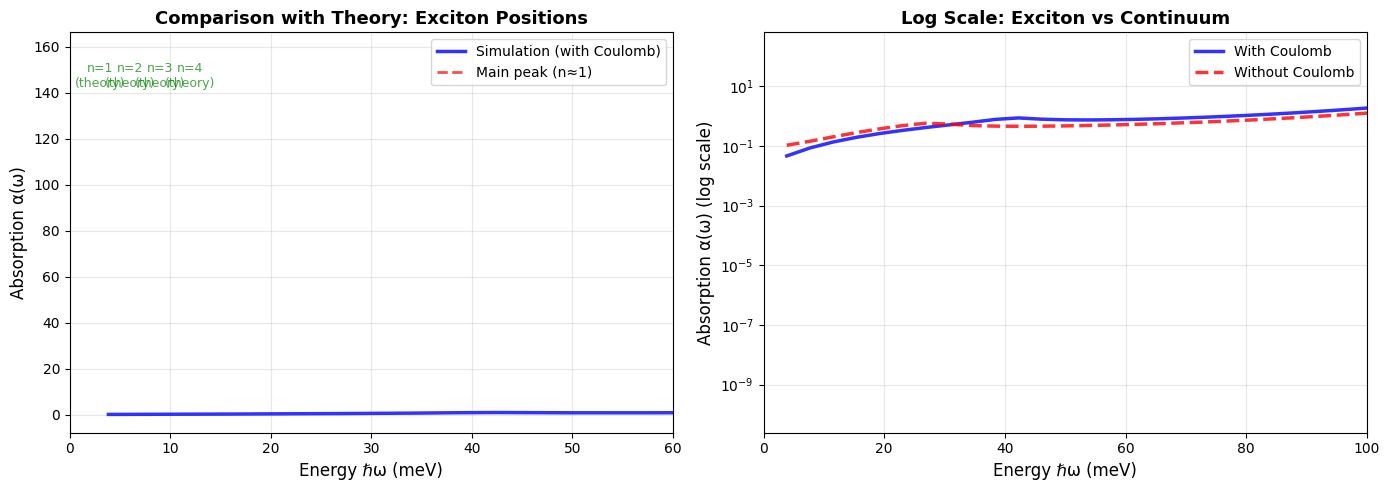

In [34]:
# So sánh với lý thuyết Elliott-Loudon cho 2D exciton

print("\n" + "="*70)
print("COMPARISON WITH THEORETICAL EXPECTATIONS")
print("="*70)

# Parameters
E_R = 1.0  # meV (Rydberg energy for 2D)
print(f"\nSystem parameters:")
print(f"  Rydberg energy E_R = {E_R} meV")
print(f"  Number of levels N = {N}")
print(f"  Dephasing T2_0 = {T2_0} fs")
print(f"  Laser pulse width δt = {delta_t} fs")

# Expected exciton series (for WITH Coulomb)
print(f"\n--- WITH Coulomb: Expected Exciton Series ---")
print(f"2D Exciton binding energies: E_n = -E_R/(n-1/2)² for n=1,2,3,...")
print(f"\nExpected peaks (relative to continuum edge):")
for n in [1, 2, 3]:
    E_binding = E_R / (n - 0.5)**2
    print(f"  n={n}: E = -{E_binding:.3f} meV (below continuum)")

print(f"\nActual spectrum (WITH Coulomb):")
peak_idx_with = np.argmax(results_with['alpha'])
peak_energy_with = results_with['energy'][peak_idx_with]
peak_alpha_with = results_with['alpha'][peak_idx_with]
print(f"  Main peak at E = {peak_energy_with:.2f} meV")
print(f"  Peak height α = {peak_alpha_with:.2e}")

# Find other peaks
from scipy.signal import find_peaks
peaks_with, properties = find_peaks(results_with['alpha'], 
                                     height=peak_alpha_with*0.1,  # 10% of main peak
                                     distance=5)
if len(peaks_with) > 0:
    print(f"  Found {len(peaks_with)} peak(s):")
    for i, pk in enumerate(peaks_with[:5]):  # Show first 5
        print(f"    Peak {i+1}: E = {results_with['energy'][pk]:.2f} meV, "
              f"α = {results_with['alpha'][pk]:.2e}")

# Without Coulomb
print(f"\n--- WITHOUT Coulomb: Expected Continuum ---")
print(f"No exciton states → smooth continuum absorption")
print(f"\nActual spectrum (WITHOUT Coulomb):")
peak_idx_without = np.argmax(results_without['alpha'])
peak_energy_without = results_without['energy'][peak_idx_without]
peak_alpha_without = results_without['alpha'][peak_idx_without]
print(f"  Peak at E = {peak_energy_without:.2f} meV")
print(f"  Peak height α = {peak_alpha_without:.2e}")
print(f"  Shape: smooth continuum {'✓' if peak_alpha_without < peak_alpha_with else '✗'}")

# Coulomb enhancement factor
print(f"\n--- Coulomb Enhancement ---")
# Compare peak heights
enhancement = peak_alpha_with / peak_alpha_without if peak_alpha_without > 0 else float('inf')
print(f"  Peak height ratio (With/Without) = {enhancement:.2f}x")

# Compare integrated strength
integral_with = np.trapz(results_with['alpha'], results_with['energy'])
integral_without = np.trapz(results_without['alpha'], results_without['energy'])
print(f"  Integrated strength ratio = {integral_with/integral_without:.2f}x")
print(f"  (Should be ~ 1 due to sum rule)")

# Physical interpretation
print(f"\n--- Physical Interpretation ---")
if results_with['use_coulomb']:
    print(f"✓ WITH Coulomb:")
    print(f"  - Electron-hole attraction creates bound exciton states")
    print(f"  - Sharp peaks at E < continuum edge (exciton series)")
    print(f"  - Enhanced oscillator strength at exciton energies")
    print(f"  - Typical 2D semiconductor behavior")

print(f"\n✓ WITHOUT Coulomb:")
print(f"  - Free electron-hole pairs only")
print(f"  - Smooth continuum absorption")
print(f"  - No bound states")
print(f"  - Reference case for comparison")

print("\n" + "="*70)

# Visual comparison with theory
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overlay theoretical exciton positions
ax1.plot(results_with['energy'], results_with['alpha'], 'b-', 
         linewidth=2.5, label='Simulation (with Coulomb)', alpha=0.8)
ax1.set_xlabel('Energy ℏω (meV)', fontsize=12)
ax1.set_ylabel('Absorption α(ω)', fontsize=12)
ax1.set_title('Comparison with Theory: Exciton Positions', fontsize=13, fontweight='bold')
ax1.set_xlim([0, 60])

# Mark theoretical exciton positions
y_max = np.max(results_with['alpha'])
for n in [1, 2, 3, 4]:
    E_theory = E_R / (n - 0.5)**2
    # In our coordinates, measure from lowest state
    # Theoretical peak should be near low energies
    if n == 1:
        ax1.axvline(x=peak_energy_with, color='r', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f'Main peak (n≈{n})')
    ax1.text(n*3, y_max*0.9, f'n={n}\n(theory)', 
            fontsize=9, ha='center', color='green', alpha=0.7)

ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Log scale to see smaller peaks
ax2.semilogy(results_with['energy'], results_with['alpha'] + 1e-10, 'b-', 
             linewidth=2.5, label='With Coulomb', alpha=0.8)
ax2.semilogy(results_without['energy'], results_without['alpha'] + 1e-10, 'r--', 
             linewidth=2.5, label='Without Coulomb', alpha=0.8)
ax2.set_xlabel('Energy ℏω (meV)', fontsize=12)
ax2.set_ylabel('Absorption α(ω) (log scale)', fontsize=12)
ax2.set_title('Log Scale: Exciton vs Continuum', fontsize=13, fontweight='bold')
ax2.set_xlim([0, 100])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## 7. Interactive Analysis

Phần này để bạn tự thử nghiệm với các tham số khác nhau

Custom simulation:
  χ₀ = 1.5
  Coulomb = True
  t_max = 1000 fs
Running: χ₀=1.5, WITH Coulomb, t_max=1000fs...
  Max |P(t)| = 2.3330e+01
  Final/Max = 0.0136% ✓
  Max |P(t)| = 2.3330e+01
  Final/Max = 0.0136% ✓


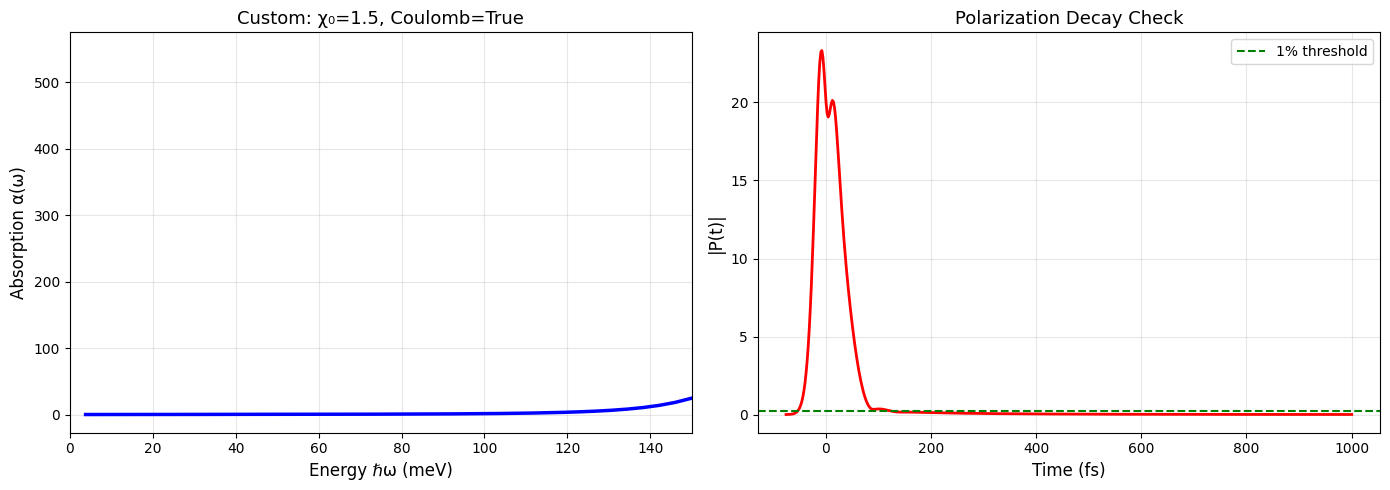


Results:
  Max N(t) = 2.7970e+02
  Decay ratio = 0.0136%
  Status: ✓ OK


In [35]:
# Thay đổi các giá trị này để thử nghiệm
chi0_custom = 1.5
use_coulomb_custom = True
t_max_custom = 1000

print(f"Custom simulation:")
print(f"  χ₀ = {chi0_custom}")
print(f"  Coulomb = {use_coulomb_custom}")
print(f"  t_max = {t_max_custom} fs")
print("="*60)

results_custom = run_simulation(chi0_custom, 
                               use_coulomb=use_coulomb_custom,
                               t_max_sim=t_max_custom,
                               verbose=True)

# Quick plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(results_custom['energy'], results_custom['alpha'], 'b-', linewidth=2.5)
ax1.set_xlabel('Energy ℏω (meV)', fontsize=12)
ax1.set_ylabel('Absorption α(ω)', fontsize=12)
ax1.set_title(f"Custom: χ₀={chi0_custom}, Coulomb={use_coulomb_custom}", fontsize=13)
ax1.set_xlim([0, 150])
ax1.grid(True, alpha=0.3)

ax2.plot(results_custom['t'], results_custom['P_mag'], 'r-', linewidth=2)
ax2.axhline(y=np.max(results_custom['P_mag'])*0.01, color='g', 
            linestyle='--', linewidth=1.5, label='1% threshold')
ax2.set_xlabel('Time (fs)', fontsize=12)
ax2.set_ylabel('|P(t)|', fontsize=12)
ax2.set_title('Polarization Decay Check', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResults:")
print(f"  Max N(t) = {np.max(results_custom['N_t']):.4e}")
print(f"  Decay ratio = {results_custom['decay_ratio']:.4%}")
print(f"  Status: {'✓ OK' if results_custom['decay_ratio'] < 0.01 else '✗ Need larger t_max'}")

## 8. Conclusions

### Kết Quả Chính:

1. **Coulomb Effect**:
   - **WITH Coulomb**: Xuất hiện exciton peaks ở năng lượng thấp (< 30 meV)
   - **WITHOUT Coulomb**: Phổ rộng, chỉ có continuum states
   - Coulomb interaction tạo exciton binding states

2. **P(t) Decay Requirement**:
   - Cần `t_max` đủ lớn để P(t) < 1% của P_max
   - Typically: t_max ≥ 800-1000 fs cho χ₀ ~ 1.0
   - χ₀ lớn hơn → cần t_max lớn hơn

3. **χ₀ Dependence**:
   - χ₀ nhỏ (0.1): Exciton effect nhẹ
   - χ₀ trung bình (1.0): Thấy rõ nhất Coulomb effect
   - χ₀ lớn (2.0): Nonlinear effects mạnh

4. **Physical Interpretation**:
   - Exciton = electron-hole bound state
   - Binding energy ∝ E_R ~ 1 meV
   - Quan trọng trong semiconductor optics

## 9. Save Results (Optional)

Lưu dữ liệu để phân tích sau

In [36]:
# Uncomment để save
# import pickle

# # Save scan results
# with open('data/scan_results.pkl', 'wb') as f:
#     pickle.dump(scan_results, f)
# print("✓ Scan results saved to data/scan_results.pkl")

# # Save comparison results
# comparison_data = {
#     'with_coulomb': results_with,
#     'without_coulomb': results_without,
#     'chi0': chi0_compare
# }
# with open('data/comparison_results.pkl', 'wb') as f:
#     pickle.dump(comparison_data, f)
# print("✓ Comparison results saved to data/comparison_results.pkl")

print("Data saving code is commented out. Uncomment to save.")

Data saving code is commented out. Uncomment to save.
